# Introduction

Hello! My name is Renan. I'm Brazilian and I actually live in Rio de Janeiro.

This dataset made me wonder how some of the independent variables are related to the rental prices in my city. That said, i am going to limit the analysis to the city of Rio de Janeiro.

So, I'm going to perform some Exploratory Data Analysis and also some Multiple Linear Regression Analysis using the Ordinary Least Squares method. By doing this, we are going to try to explain how the dataset features impact the rental prices.

I am considering the categorical variables, such as if the apartment has furniture or not, as dummy variables.

The model: 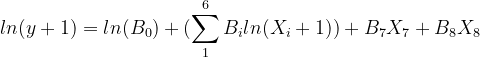


In which variables X1 - X6 are the continuos variables, and X7 and X8 are the dummies.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from scipy.stats import shapiro
%matplotlib inline

In [ ]:
houses = pd.read_csv("../input/brasilian-houses-to-rent/houses_to_rent_v2.csv")

In [ ]:
houses.info()

In [ ]:
houses.head()

In [ ]:
houses.describe()

In [ ]:
houses['city'].unique() ### No problem on cities names.

In [ ]:
rio = houses[houses['city'] == "Rio de Janeiro"]

In [ ]:
rio['animal'].unique()   ## Boolean variable, so we are going to transform this text variable into a dummy variable

In [ ]:
rio.loc[:,'animal'] = rio['animal'].apply(lambda x: 1 if x == 'acept' else 0) # if 1 -> place accepts animals.

In [ ]:
rio.head()

In [ ]:
rio.loc[:, 'furniture'].unique()   # Same happens.That said we can make that column a dummy variable. 
                                   # 1 is going to represent furnished places. 

In [ ]:
rio.loc[:, 'furniture'] = rio['furniture'].apply(lambda x: 1 if x == 'furnished' else 0)

In [ ]:
rio.head()

In [ ]:
rio['floor'].unique() # We need to deal with the '-' value.

In [ ]:
rio['floor'].value_counts() # We still get a lot of data points if we drop those rows in which we have the
                            # "-" value for the floor variable, so we might as well drop them.

In [ ]:
bye = rio[rio['floor'] == "-"].index ## Getting the indexes of the rows which have the value "-" for the floor variable

In [ ]:
rio = rio.drop(bye)

In [ ]:
rio['floor'] = rio['floor'].apply(lambda x: int(x))

In [ ]:
rio.head()

In [ ]:
rio.info()

In [ ]:
rio = rio.drop(axis = 1, columns = ['property tax (R$)', 'total (R$)', 'hoa (R$)', 'fire insurance (R$)'])

# Exploratory Data Analysis (EDA)

We are going to begin the analysis doing some EDA, just to take a look at our data, and see what is going on, what are the correlations between variables, and check for possible multicolinearity.

In [ ]:
plt.figure(figsize = (15,8))
sns.heatmap(rio.corr(), annot = True) ## Floor and animal variables seems not quite related to anything

In [ ]:
sns.pairplot(rio)
plt.tight_layout()

We can see that some of the distributions are positive skewed, so we are going to use the Log transformation to reduce the high leverage values impact, and possible future problems with heterocedasticity.

In fact, for the model, we are going to use the x = log(x+1) transformation, since the parking spaces 
variable assume 0 values, and the log of 0 is not defined.

That said, our model will be a log-log linear model.

In [ ]:
plt.figure(figsize = (15,6))


plt.subplot(1, 2, 1)
plt.title("Comparison between the standard distriution and Log10 transformed distribution")
sns.distplot(a = rio['rent amount (R$)'])

plt.subplot(1, 2, 2)
sns.distplot(a = np.log(rio['rent amount (R$)']+1))   



In [ ]:
plt.figure(figsize = (15,6))


plt.subplot(1, 2, 1)
plt.title("Comparison between the standard distriution and Log10 transformed distribution")
sns.distplot(a = rio['floor'])

plt.subplot(1, 2, 2)
sns.distplot(a = np.log(rio['floor']+1))

In [ ]:
newOrder = ['city','area','rooms','bathroom','parking spaces','floor','rent amount (R$)', 'furniture', 'animal']
rio = rio[newOrder]
rio = rio.drop(labels = 'city', axis = 1)
rio.head()     #Changing order of columns in order to separate continous variables and dummy variables

In [ ]:
rioCont, rioDummy = rio.loc[:, 'area':'rent amount (R$)'], rio.loc[:, 'furniture':'animal'] 

In [ ]:
rioCont = np.log(rioCont + 1)

In [ ]:
newRio = pd.concat([rioCont, rioDummy], axis = 1, join = 'inner')
newRio.head()

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(newRio.corr())

In [ ]:
sns.pairplot(newRio)

In [ ]:
sns.distplot(a = newRio['parking spaces'])  #Parking spaces is still messed up =( 

In [ ]:
sns.lmplot(data = newRio, x = 'area', y = 'rent amount (R$)')  # Data suggests strong linear relation between the rent values and the area

# Checking for multicolinearity

In order to look for annoying multicolinearity in our data, we are going to take a look on the Variance Inflation Factor (VIF), which is really nothing fancy. The VIF is just an statistic generated from the R squared value of the linear regression of the independent variable we are checking for multicolinearity onto the remaining independent variables. 

Usual VIF thresholds are 5 or 10 (HASTIE et al, 2013). If we have values greater than those, we should deal with multicolinearity, even discarding the said variable, or mixing it with other independent variables and creating a new indicator. For more reading on the VIF: https://en.wikipedia.org/wiki/Variance_inflation_factor

In [ ]:
# First we create a simple function for getting the VIFs for each feature of the dataset

def vif(dataframe, add_intercept = True):
    if add_intercept == True:
        dataframe = sm.add_constant(dataframe)
        
    for i in dataframe.columns:
        y = dataframe[[i]]
        x = dataframe.drop(labels = i, axis = 1)
        model = sm.OLS(y, x)
        results = model.fit()
        rSquared = results.rsquared
        vifValue = round(1/(1 - rSquared), 2)

        print('---------------------------------------------------------------------------------------------')
        print("The regression of the independent variable ", str.upper(i), " returns a R squared value of: ", rSquared)
        print('\nThat said, the VIF for this variable is: ', vifValue)
        

In [ ]:
vif(rio)   # VIFs are low, so we can assume that multicolinearity is not a problem (we can ignore the constant VIF).

# Model Estimation

In order to adjust the skewness in the dependent variable and in some of the independent variables, we are going to use the log-log linear model for the Linear Regression, but keeping the dummy variables in the regular form (because we can't take the log of 0, and log 1 = 0).

Also, our parking places variable takes 0 values, so our transformation actually is going to be: Bi * Xi => Bi* Ln * (Xi + 1) 

That said, our transformed linear regression model is: Ln(y+1) = Ln (B0 + 1) + B1Ln(x+1) + B2Ln(x+1) + ... + B7X7 + B8X8  -> Last two variables are the dummy ones.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
list(newRio.columns)

newCols = ['area',
 'rooms',
 'bathroom',
 'parking spaces',
 'floor',
 'furniture',
 'animal','rent amount (R$)']

newRio = newRio[newCols]
newRio.head()                  #Changing order of cols to put rent value in the end

In [ ]:
X = newRio.loc[:, 'area':'animal']
y = newRio['rent amount (R$)']

print(X.head())
print(y.head())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

In [ ]:
import statsmodels.api as sm       # Statsmodels for the regression summary

Here we are going to use the function sm.add_constant in order to add a column of 1s in the dataset. That is necessary for fitting a linear model with intercept in statsmodels. For more details check the documentation for the sm.OLS function on their website:

https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html

In [ ]:
X_constant = sm.add_constant(X_train) 

In [ ]:
model = sm.OLS(y_train, X_constant).fit()
predictions = model.predict(X_constant) 

In [ ]:
print_model = model.summary()    
print(print_model)

For a confidence of 5%, the "parking spaces" variable isn't statistically relevant (p-value of 18,6%), so, we are dropping it.

In [ ]:
X_constant = X_constant.drop(['parking spaces'], axis = 1) 

In [ ]:
model = sm.OLS(y_train, X_constant).fit()
predictions = model.predict(X_constant) 
print_model = model.summary()    
print(print_model)

# Checking for Serial correlation and Normality of residuals

In [ ]:
#Evaluating Serial Autocorrelation
residuals = y_train - predictions
sns.scatterplot(x = predictions, y = residuals)
plt.title("Fitted values x Residuals")
plt.ylabel("residuals")
plt.xlabel("fitted values")

#Residuals seem random, no signs of autocorrelation.

In [ ]:
#Evaluating residuals distribution
sns.distplot(residuals)
plt.title("Residuals Distribuition")
plt.xlabel("Residuals")

# Distribution seems roughly normal, so we are fine.

# Evaluating the model

For evaluating the prediction capabilities of the model, we are going to use the train_test_split process. This method consists in dividing the available data in two parts: The training data and the test data.

The training data is the one we are going to use to estimate the parameters and fit our model. We should do that in order to have a set of data available for testing the model after its development, so we can check if our model's prediction capacity is good only because it's biased to our data.

That said, the test data is the one we are using for actually testing the model's prediction capability to a new set of data. That's the performance we should expect after testing the model on new real world data.

Besides that, we are going to build some statistics in order to evaluate the model's precision and accuracy. Since we have many lines (n > 1000), we are using a ratio between the Root-mean squared error (RMSE) and the mean of the predicted values to estimate how off our fitted values are from the real data, on average.

So the ratio formula is: ratio = RMSE / mean(y_test)

In [ ]:
X_test_no_parking = X_test.drop(axis = 1, labels = 'parking spaces')

In [ ]:
X_test_no_parking_constant = sm.add_constant(X_test_no_parking)

In [ ]:
forecasting = model.predict(X_test_no_parking_constant)
forecasting

In [ ]:
test_residuals = y_test - forecasting

In [ ]:
RSS = sum((test_residuals)**2)   #Residual Sum of Squares
TSS = sum((y_test - y_test.mean())**2)   #Total Sum of Squares
rSquared = (TSS - RSS)/TSS
RMSE = np.sqrt(RSS/len(test_residuals))
ratio = RMSE/y_test.mean()

print("The Residual Sum of Squares: ", RSS)
print("The total sum of squares: ", TSS)
print("The R squared: ", rSquared)
print("The Root-mean squared error: ", RMSE)
print("The ratio between the RMSE and the mean of the test data (y_test.mean()): ", round(ratio,4))

Models seems pretty good. We have a R squared of ~ 57%, that means, amongst the total variability of the output variable, the variance explained by the model correspond to 57% of the total.

Besides, our ratio is roughly 6%. We can interpret that as: If we are using our model to predict the rental prices, our predictions will be, on average, off by 6% of the real data.

# Forecasting

For a quick example of predicting new data, i'll select a row of the test data and check our predictions for that, and the confidence intervals of our predictions.

We could do the same process for new data that appears.

In [ ]:
X_test_no_parking_constant.loc[495,:]

In [ ]:
guess = model.get_prediction(X_test_no_parking_constant.loc[495,:])

In [ ]:
guess.summary_frame(alpha = 0.05)  #setting the value for alpha. Our confidence interval will be of 95%

Since we have a log-log model, we need to undo the log(x+1) transformations, both on the dependent and on the independent variables, in order to have access to the real data. Ignore the transformations on const and on the dummy variables (furniture and animal). 

In [ ]:
np.exp(X_test_no_parking_constant.loc[495,:])-1   #just taking the row labeled as 495 as a sample.

In [ ]:
print("Upper confidence interval",np.exp(7.880193)-1)
print("Expected value: ", np.exp(7.83814)-1)
print("Lower confidence interval: ", np.exp(7.796087)-1)

In [ ]:
print("Real data point: ",np.exp(7.824446)-1)  #Very good!

# Conclusion

The model provided satisfying prediction for the rental values. A 6% ration between the RMSE and the mean of the Y real data is pretty satisfying and the model can make good and useful predictions. It would be very interesting to have access to more features, like the neighborhood of the apartment, for example. With new useful information, we should be able to increase the amount of explained variability and improve the model's interpretation.

That said, that was a really fun and interesting work to do. Feel free to leave comments and feedbacks. Thank you!

# References

Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani. An Introduction to Statistical Learning : with Applications in R. New York :Springer, 2013.
